In [3]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
# from mean_reversion import mean_reversion_strategy, backtest, fetch_data
random_state = 0
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns
import xgboost as xgb
sys.path.append(os.path.dirname(os.getcwd()))
from Technical_Indicators.Mean_Reversion.data_prep import fetch_data, time_series_features, add_lag_features


### Fetch Data

In [3]:
df = fetch_data('XOM', '2000-01-01', '2023-12-31')
# df = data_prep.mean_reversion_strategy(df)
# result_df, mets = backtest(df)
# print(mets)
df['YoY_Close'] = df['Close'].pct_change(periods=252)
df_yoy = df.dropna(subset=['YoY_Close'])

Decided to add Year on Year change to visualise seasonality


### Data Preparation

In [4]:
df = add_lag_features(df)

In [5]:
df2 = time_series_features(df)


C:\Users\Tristan\AppData\Local\Temp\ipykernel_11116\2911194834.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df2, x='month', y='YoY_Close', palette='viridis')


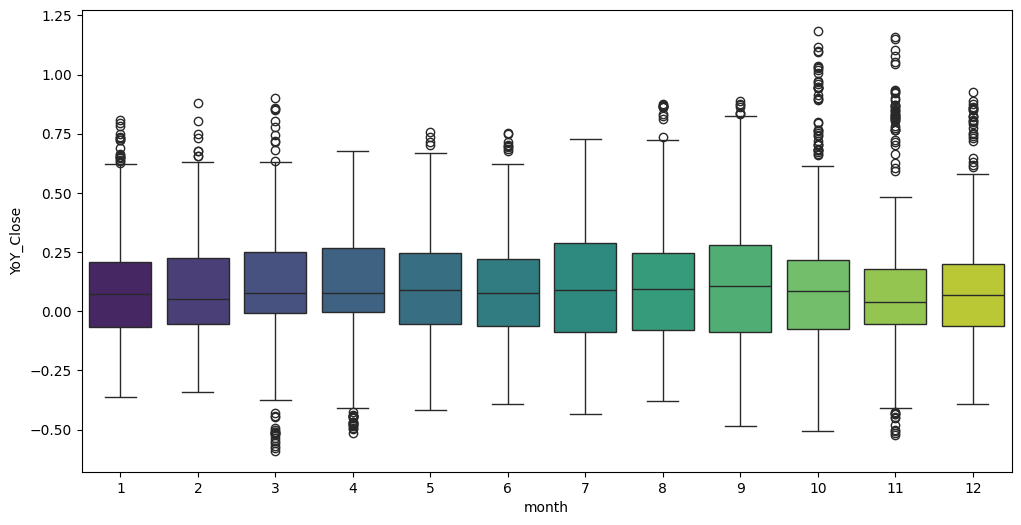

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data = df2, x='month', y='YoY_Close', palette='viridis')
plt.show()



Looking at the median YoY change for each month, we can see that there is some seasonality occuring throughout the year, however it is not consistent.


### Model

In [7]:
train = time_series_features(df.loc[df.index < '2023-06-30'])
test = time_series_features(df.loc[df.index >= '2023-06-30'])

In [8]:
features = ['Volume','day_of_week', 'month',
            'is_month_end', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_5', 'Close_lag_10']
target = 'Close'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=5, early_stopping_rounds=1000)



In [9]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose = True)

[0]	validation_0-rmse:17.34834	validation_1-rmse:52.91249
[1]	validation_0-rmse:15.63401	validation_1-rmse:47.75578
[2]	validation_0-rmse:14.08979	validation_1-rmse:43.11777
[3]	validation_0-rmse:12.69828	validation_1-rmse:38.91676
[4]	validation_0-rmse:11.44545	validation_1-rmse:35.19397
[5]	validation_0-rmse:10.31762	validation_1-rmse:31.79539
[6]	validation_0-rmse:9.30218	validation_1-rmse:28.77781
[7]	validation_0-rmse:8.38813	validation_1-rmse:26.05397
[8]	validation_0-rmse:7.56543	validation_1-rmse:23.56638
[9]	validation_0-rmse:6.82498	validation_1-rmse:21.32003
[10]	validation_0-rmse:6.15896	validation_1-rmse:19.30335
[11]	validation_0-rmse:5.55997	validation_1-rmse:17.48353
[12]	validation_0-rmse:5.02137	validation_1-rmse:15.85106
[13]	validation_0-rmse:4.53740	validation_1-rmse:14.40233
[14]	validation_0-rmse:4.10267	validation_1-rmse:13.05193
[15]	validation_0-rmse:3.71240	validation_1-rmse:11.85744
[16]	validation_0-rmse:3.36246	validation_1-rmse:10.80575
[17]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=1000,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
pd.DataFrame(data = model.feature_importances_,
             index = model.feature_names_in_)

,0
Volume,0.000238
day_of_week,0.000193
month,0.000364
is_month_end,0.000245
Close_lag_1,0.887630
Close_lag_2,0.062641
Close_lag_3,0.017760
Close_lag_5,0.012936
Close_lag_10,0.017992
